# Using _egobox_ surrogate model _Gpx_

## Installation

In [27]:
%pip install egobox

Note: you may need to restart the kernel to use updated packages.


We import _egobox_ as _egx_ for short

In [28]:
import egobox as egx

# Example 1 : Gpx basics

### Training 

#### Training data definition

In [29]:
import numpy as np

xt = np.array([[0.0, 1.0, 2.0, 3.0, 4.0]]).T
yt = np.array([[0.0, 1.0, 1.5, 0.9, 1.0]]).T

#### Building the surrogate

In [30]:
gpmix = egx.Gpx.builder()
gpmix.set_training_values(xt, yt)
gpx = gpmix.train()

### Prediction

#### Using the surrogate for estimation

In [31]:
# number of x locations to estimate
num = 100

# x should have 2D shape (nsamples, nx)
x = np.linspace(0.0, 4.0, num).reshape((-1, 1))

# estimated values
y = gpx.predict_values(x)
# estimated variances
s2 = gpx.predict_variances(x)

#### Plotting results

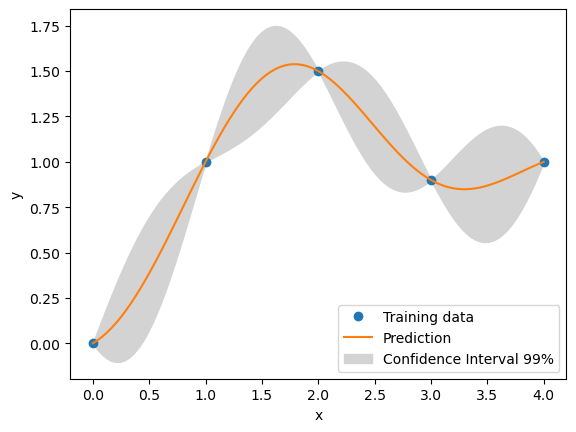

In [32]:
import matplotlib.pyplot as plt

def plot_gp(xt, yt, x, y, s2):
    fig, axs = plt.subplots(1)
    
    # training data
    axs.plot(xt, yt, "o")
    
    # gp mean
    axs.plot(x, y)
    
    # 99% confidence interval
    axs.fill_between(
        np.ravel(x),
        np.ravel(y - 3 * np.sqrt(s2)),
        np.ravel(y + 3 * np.sqrt(s2)),
        color="lightgrey",
    )
    
    # legend
    axs.set_xlabel("x")
    axs.set_ylabel("y")
    axs.legend(
        ["Training data", "Prediction", "Confidence Interval 99%"],
        loc="lower right",
    )
    return axs

plot_gp(xt, yt, x, y, s2)
plt.show()

### Sampling

#### Sampling the conditionned Gaussian process

In [33]:
# number fo trajectories to sample
n_traj = 30

trajs = gpx.sample(x, n_traj)

#### Plotting trajectories

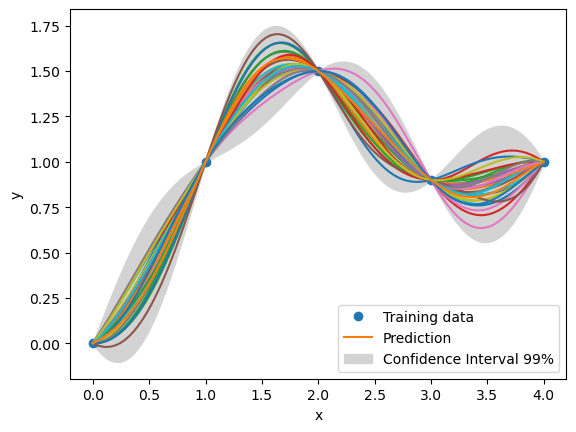

In [34]:
axs = plot_gp(xt, yt, x, y, s2)

for i in range(n_traj):
    axs.plot(x, trajs[:, i])

plt.show()

## Example 2 : Gpx trend and correlation models customization, saving and loading

### Test function

$$f : \left\{ \begin{array}{c} [-10, 10] \rightarrow \mathbb{R} \\ x \mapsto x^2 \sin(x) \ \end{array} \right.$$

In [35]:
import numpy as np

def f(x):
    return x**2 * np.sin(x)

### Training

$f$ is approximated with _Gpx_ at points $-8.5$,  $-4.0$,  $-3.0$,  $-1.0$, $4.0$ and  $7.5$. 

In [36]:
xt = np.array([[-8.5, -4.0, -3.0, -1.0, 4.0, 7.5]]).T
yt = f(xt)

To show features of _Gpx_, below, we build the surrogate asking for best GP regression by testing constant, linear or quadratic trend with either squared_exponential or matern52. The quality of the surrogate is assessed by cross validation.

In [37]:
gpx_builder = egx.Gpx.builder(regr_spec=egx.RegressionSpec.ALL, 
                              corr_spec=egx.CorrelationSpec.SQUARED_EXPONENTIAL | egx.CorrelationSpec.MATERN52)
gpx_builder.set_training_values(xt, yt)
gpx = gpx_builder.train()

We can get string representations of the trained GP

In [38]:
print(f"Gpx string: {gpx}")
print(f"Gpx stringified JSON serialization {repr(gpx)}")

Gpx string: Mixture[Smooth](Linear_SquaredExponential)
Gpx stringified JSON serialization {"recombination":{"Smooth":null},"experts":[{"type":"GpLinearSquaredExponentialSurrogate","theta":{"v":1,"dim":[1],"data":[14.452847107646573]},"mean":"LinearMean","corr":"SquaredExponential","inner_params":{"sigma2":{"v":1,"dim":[1],"data":[441.21424658059647]},"beta":{"v":1,"dim":[2,1],"data":[-0.0775716724236349,0.7944037440941787]},"gamma":{"v":1,"dim":[6,1],"data":[-0.44643171895868494,1.1331420143375075,-0.3878808158729566,0.1553424166083581,-0.8959678960135354,0.44179599989931173]},"r_chol":{"v":1,"dim":[6,6],"data":[1.000000000000011,0.0,0.0,0.0,0.0,0.0,0.00015108015745397363,0.999999988587404,0.0,0.0,0.0,0.0,1.9606328843533654e-6,0.6476179687277245,0.761965200371483,0.0,0.0,0.0,2.4360561936201813e-11,0.020038719831975402,0.21382406242739627,0.9766666371052933,0.0,0.0,3.300470378132294e-30,8.402502855479929e-13,7.45202400028961e-10,0.0000196436494085873,0.9999999998070745,0.0,4.98464983484

... and save it in a json file.

In [39]:
gpx.save("gp.json")

We can reload it with

In [40]:
gpx = egx.Gpx.load("gp.json")

### Prediction

In [41]:
x_min, x_max = -10, 10
n_plot = 500

# x must have (nsamples, nx) shape
x = np.linspace(x_min, x_max, n_plot).reshape(-1, 1)

y = gpx.predict_values(x)
s2 = gpx.predict_variances(x)

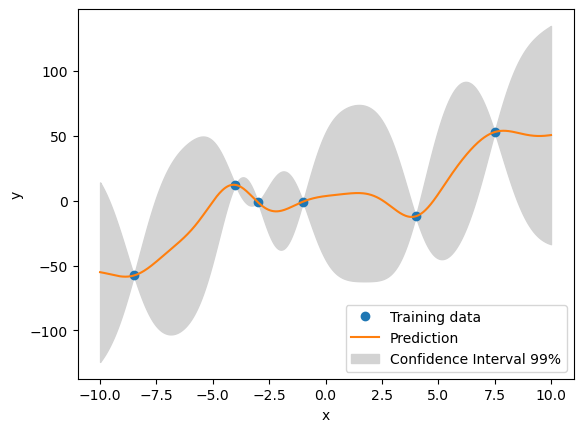

In [42]:
plot_gp(xt, yt, x, y, s2)
plt.show()

### Sampling

#### Sampling the conditionned Gaussian process

In [43]:
# number fo trajectories to sample
n_traj = 10

trajs = gpx.sample(x, n_traj)

#### Plotting trajectories

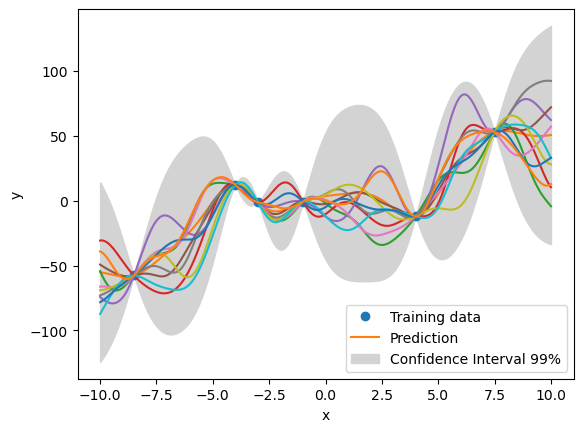

In [44]:
axs = plot_gp(xt, yt, x, y, s2)

for i in range(n_traj):
    axs.plot(x, trajs[:, i])

plt.show()

## Example 3 : Clustering

### Test function

We are going to use a test function with three modes to show clustering feature

In [45]:
def function_3modes(x):
    y = np.zeros(x.shape)
    y[x < 0.4] = x[x < 0.4] ** 2
    y[(x >= 0.4) & (x < 0.8)] = 3 * x[(x >= 0.4) & (x < 0.8)] + 1
    y[x >= 0.8] = np.sin(10 * x[x >= 0.8])
    return y

### Training 

#### Training data definition

In [46]:
np.random.seed(42)  # results may differ depending on training data, set seed here for reproducibility
xt = np.random.sample(60).reshape((-1, 1))
yt = function_3modes(xt)

#### Building the surrogate

In [47]:
gpmix = egx.Gpx.builder(n_clusters=3)
gpmix.set_training_values(xt, yt)
gpx = gpmix.train()

In [48]:
print(gpx)

Mixture[Smooth(0.1)](Constant_SquaredExponential, Constant_SquaredExponential, Constant_SquaredExponential)


We see that 3 experts are smoothly recombined with an heasviside factor of 0.1 automatically adjusted to improve the overall surrogate quality.

### Plotting

In [49]:
x_min, x_max = 0, 1
n_plot = 500

# x must have (nsamples, nx) shape
x = np.linspace(x_min, x_max, n_plot).reshape(-1, 1)

y = gpx.predict_values(x)
s2 = gpx.predict_variances(x)

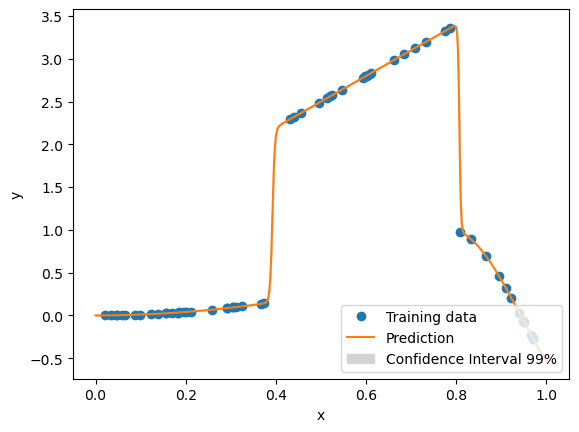

In [50]:
plot_gp(xt, yt, x, y, s2)
plt.show()

We can check it is better than one cluster (the default).

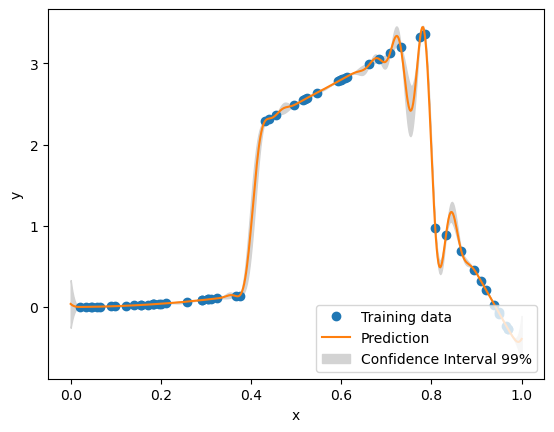

In [51]:
gpmix = egx.Gpx.builder()
gpmix.set_training_values(xt, yt)
gpx = gpmix.train()
y = gpx.predict_values(x)
s2 = gpx.predict_variances(x)
plot_gp(xt, yt, x, y, s2)
plt.show()

We can also let _Gpx_ find the  best number of clusters

Mixture[Hard](Constant_SquaredExponential, Constant_SquaredExponential, Constant_SquaredExponential)


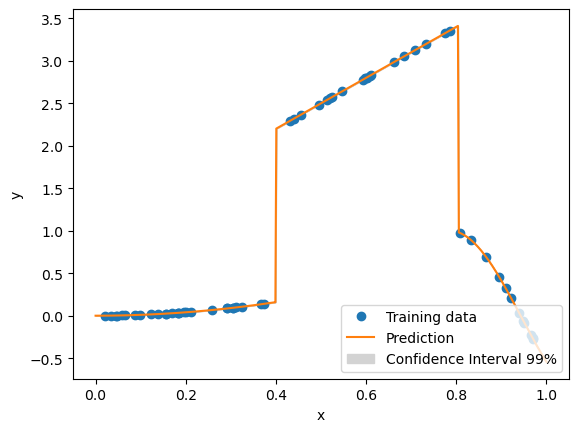

In [52]:
gpmix = egx.Gpx.builder(n_clusters=0)
gpmix.set_training_values(xt, yt)
gpx = gpmix.train()
print(gpx)
y = gpx.predict_values(x)
s2 = gpx.predict_variances(x)
plot_gp(xt, yt, x, y, s2)
plt.show()